In [164]:
# try to use cellpose to segment cells
import numpy as np
import pandas as pd
import time, os, sys, glob
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.ndimage import find_objects
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
files = []
path = r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO"
os.chdir(path)
for file in glob.glob("*.tif"):
    files.append(os.path.join(path, file))

In [ ]:
# I will download images from website
# urls = ['http://www.cellpose.org/static/images/img02.png',
#         'http://www.cellpose.org/static/images/img03.png',
#         'http://www.cellpose.org/static/images/img05.png']
# files = []
# for url in urls:
#     parts = urlparse(url)
#     filename = os.path.basename(parts.path)
#     if not os.path.exists(filename):
#         sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
#         utils.download_url_to_file(url, filename)
#     files.append(filename)

# REPLACE FILES WITH YOUR IMAGE PATHS


# files = ['img0.tif', 'img1.tif']


In [ ]:
files[80:120]

In [ ]:
import tracemalloc
filename = r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\T0D2_1.tif"
model = models.Cellpose(gpu=True, model_type ='cyto')
tracemalloc.start()
img = io.imread(filename)
masks, flows, styles, diams = model.eval(img, 
                            batch_size = 8,
                         diameter= diam, 
                         channels=chan,
                         invert = True,
                         flow_threshold = 0,
                         cellprob_threshold = -4,
                                        )

current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
tracemalloc.stop()

In [ ]:
# RUN CELLPOSE

from cellpose import models, io

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type ='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
channels = [[0,0]] * len(files) # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
# channels = [[0,0], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

# you can run all in a list e.g.
# >>> imgs = [io.imread(filename) in files]
# >>> masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)
# >>> io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# >>> io.save_to_png(imgs, masks, flows, files)
diam = 100
# or in a loop
for chan, filename in zip(channels, files[:]):
    name, file_extension = os.path.splitext(filename)
    filename = r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\T0D2_1.tif"
#     if os.path.exists(name + "_seg.npy"):
#         continue
#     else:
    print (filename)
    try:
        img = io.imread(filename)
        masks, flows, styles, diams = model.eval(img, 
                                 diameter= diam, 
                                 channels=chan,
                                 invert = True,
                                 flow_threshold = 1,
                                 cellprob_threshold = -4,
                                                )

        # save results so you can load in gui
#         io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)

        # save results as png
#         io.save_to_png(img, masks, flows, filename)
    except Exception as err:
        print (err)
    break

In [ ]:
img = io.imread(filename)

In [ ]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
# plt.show()

In [ ]:
plt.imshow(masks)

In [ ]:
txt_files = []
path = r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO"
os.chdir(path)
for file in glob.glob("*.txt"):
    txt_files.append(os.path.join(path, file))
print (len(txt_files))

##### Save individual crops

In [ ]:
for fname in txt_files[2::5]:
    # get sample ifo
    foldername, file_extension = os.path.splitext(fname)
    foldername = foldername.split("_cp")[0]
    # load cell outlines 
    file1 = open(fname,"r+")
    ls_outlines = file1.readlines()
    file1.close() 
    # load corresp image
    img_path = foldername + ".tif"
    print(img_path)
    img = io.imread(img_path)
    foldername = foldername + "_un"
    # create folder to save crops
    if not os.path.exists(foldername):
        os.makedirs(foldername)
    
    for idx, cell in enumerate(ls_outlines[::10]):
        # get coordinates of the contour
        x = cell[:-1].split(",")[::2]
        x = [int(i) for i in x]
        y = cell[:-1].split(",")[1::2]
        y = [int(i) for i in y]
        # create list of tuples for cv2
        out_pix = np.array(list(zip(x, y)))
        
        # mask outline
        mask = np.zeros(img.shape, dtype=np.uint8)
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,)*channel_count
        # fill contour
        cv2.fillConvexPoly(mask, out_pix, ignore_mask_color)

        masked_image = cv2.bitwise_and(img, mask)
        
        # crop the box around the cell
        (topy, topx) = (np.min(y), np.min(x))
        (bottomy, bottomx) = (np.max(y), np.max(x))
        out = masked_image[topy:bottomy+1, topx:bottomx+1,:]
        
        # find purple patches to save only infected cells
        hsv = cv2.cvtColor(out, cv2.COLOR_RGB2HSV)
        lower_range = np.array([120,50,50])
        upper_range = np.array([150,255,255])
        color_mask = cv2.inRange(hsv, lower_range, upper_range)
        pixel_sum = color_mask.sum()

    #     plt.plot(x, y)
        if pixel_sum > 3e4:
            print (pixel_sum)
#             f, ax = plt.subplots(1, 2, figsize=(4,4))
#             ax[0].imshow(out)
#             ax[1].imshow(color_mask)
#             ax[0].axis('off')
#             ax[1].axis('off')
#             plt.show()
#             plt.savefig(os.path.join(foldername, os.path.basename(name) + str(idx) + ".png" ))
#             cv2.imwrite(os.path.join(name, str(idx) + ".png" ), out)
#             im = Image.fromarray(out)
#             im.save(os.path.join(foldername, os.path.basename(foldername) + str(idx) + ".png" ))
        else:
            im = Image.fromarray(out)
            im.save(os.path.join(foldername, os.path.basename(foldername) + str(idx) + ".png" ))
    

In [ ]:
outlines = utils.masks_to_outlines(masks)

# plot the WordCloud image     
fig, ax = plt.subplots(figsize = (12, 12))                   
outX, outY = np.nonzero(outlines)
imgout = img.copy()
imgout[outX, outY] = np.array([255,75,75])
ax.imshow(imgout)
#for o in outpix:
#    ax.plot(o[:,0], o[:,1], color=[1,0,0], lw=1)
ax.set_title('predicted outlines')
ax.axis('off')
ax.invert_yaxis()

In [ ]:
path_txt = r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\T32D2_1_cp_outlines.txt"
file1 = open(path_txt,"r+")
outlines = file1.readlines()

file1.close() 

In [ ]:
for cell in outlines:
    x = cell[:-1].split(",")[::2]
    x = [int(i) for i in x]
    y = cell[:-1].split(",")[1::2]
    y = [int(i) for i in y]
    out_pix = list(zip(x, y))
    break

### Prepare individual crops for classification

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
def transform_image(arr):
    my_transforms = transforms.Compose([
                                    transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        [0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225])])
#     image = Image.open(io.BytesIO(image_bytes))
    im = Image.fromarray(arr)
    return my_transforms(im).unsqueeze(0)

In [273]:
class_names = ["un", 'ring', 'troph', 'shiz']

def get_prediction(arr):
    tensor = transform_image(arr)
    outputs = pred_model.forward(tensor)
    _, y_hat = outputs.max(1)
    return class_names[y_hat]

In [170]:
from cellpose.utils import outlines_list

In [ ]:
class_names = ["un", 'ring', 'troph', 'shiz']

In [272]:
device = torch.device('cpu')
# Load
PATH = r"C:\Users\AChub_Lab\Desktop\my_project\st_app\malaria-detection-classification\model.pth"
pred_model = torch.load(PATH, map_location = device)
pred_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Approach 1: outlines list

In [177]:
def get_crop_from_outline(cell, tmp_img):
    # get xy coords
    x = cell.flatten()[::2]
    y = cell.flatten()[1::2]
    # mask outline
    mask = np.zeros(tmp_img.shape, dtype=np.uint8)
    channel_count = tmp_img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,)*channel_count
    # fill contour
    cv2.fillConvexPoly(mask, cell, ignore_mask_color)
    masked_image = cv2.bitwise_and(tmp_img, mask)
    # crop the box around the cell
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = masked_image[topy:bottomy+1, topx:bottomx+1,:]
    return out

### Run segmentation and classification

In [305]:
len(files)

150

** TORCH CUDA version installed and working. **
>>>> using GPU
********** T0D1_1.tif **********
processing 1 image(s)


C:\Users\AChub_Lab\anaconda3\envs\pytorch_ap\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


time spent: running network 0.94s; flow+mask computation 1.17
estimated masks for 1 image(s) in 2.36 sec
>>>> TOTAL TIME 2.36 sec


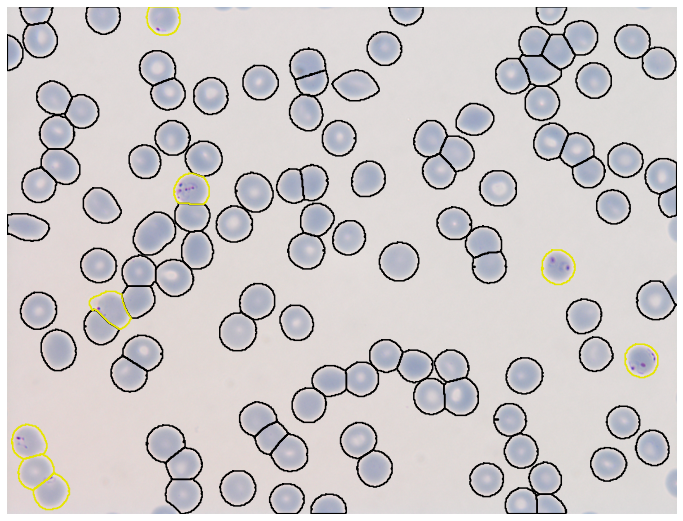

  stage  cell_idx      paras
0  ring         8   1.913876
1    un       106  25.358852
Total cell count: 114
Infected cells:  8
Parasite density:  1.9139 %
********** Finished processing **********


********** T0D1_2.tif **********
processing 1 image(s)


C:\Users\AChub_Lab\anaconda3\envs\pytorch_ap\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


time spent: running network 0.95s; flow+mask computation 1.19
estimated masks for 1 image(s) in 2.39 sec
>>>> TOTAL TIME 2.39 sec


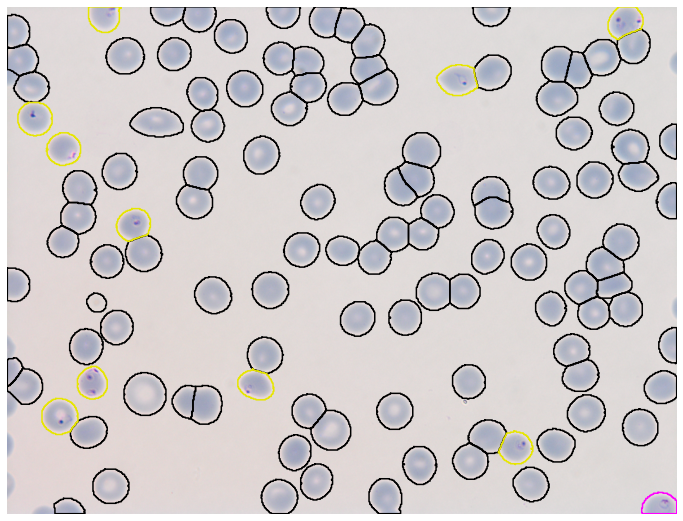

   stage  cell_idx      paras
0   ring        10   2.392344
1  troph         1   0.239234
2     un       107  25.598086
Total cell count: 118
Infected cells:  11
Parasite density:  2.6316 %
********** Finished processing **********


********** T0D2_1.tif **********
processing 1 image(s)


C:\Users\AChub_Lab\anaconda3\envs\pytorch_ap\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


time spent: running network 0.93s; flow+mask computation 2.65
estimated masks for 1 image(s) in 3.82 sec
>>>> TOTAL TIME 3.82 sec


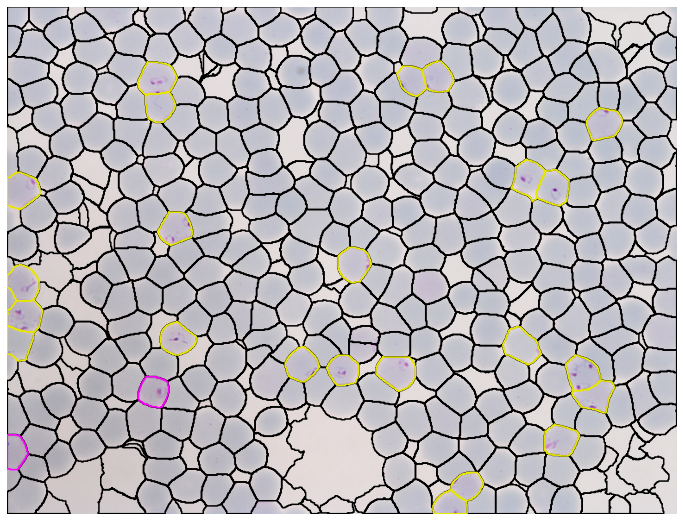

   stage  cell_idx      paras
0   ring        23   5.502392
1  troph         2   0.478469
2     un       393  94.019139
Total cell count: 418
Infected cells:  25
Parasite density:  5.9809 %
********** Finished processing **********




In [304]:
# RUN CELLPOSE
model = models.Cellpose(gpu=True, model_type ='cyto')
channels = [[0,0]] * len(files) # IF YOU HAVE GRAYSCALE
diam = 100

# or in a loop
for chan, filename in zip(channels, files[:3]):
    print('*'*10, filename.split('\\')[-1], '*'*10)
#     print (filename)
    try:
        img = io.imread(filename)
        masks, flows, styles, diams = model.eval(img, 
                                 diameter= diam, 
                                 channels=chan,
                                 invert = True,
                                 flow_threshold = 1,
                                 cellprob_threshold = -4,
                                                )

    except Exception as err:
        print (err)
        
    size_thres = diam*0.6
    tmp_img = img.copy()
    
    d_results = {"un": [], "ring": [], "troph": [], "shiz": [] }
    outlines_ls = outlines_list(masks)
    with torch.no_grad():
        for idx, cell in enumerate(outlines_ls[:]):
            # get crop
            out = get_crop_from_outline(cell, tmp_img)
            if out.shape[0] < size_thres or out.shape[1] < size_thres:
                continue
            tensor = transform_image(out)
            # get prediction
            stage = get_prediction(out)
            d_results[stage].append(idx)
            
    f, ax = plt.subplots(figsize = (12, 12))
    ax.cla()
    # yellow: ring; magenta: troph; cyan: shiz

    colors_stage = { "un": [0, 0, 0], "ring": [0.9, 0.9, 0], 
        "troph": [1, 0, 1], "shiz": [0, 1, 1]
    }
    ax.imshow(img)
    ax.axis('off')
    for k in class_names:
        if len(d_results[k]) > 0:
            for cell in d_results[k]:
                coord = outlines_ls[cell]
                ax.plot(coord[:,0], coord[:,1], color = colors_stage[k], lw=1.5)
    plt.show()
    
    df_res = 0
    df_res = pd.DataFrame.from_dict(d_results, orient = 'index').stack().reset_index()
    df_res.columns = ['stage', '_' ,'cell_idx']
    del df_res["_"]
    df_res = df_res.groupby('stage').count().reset_index()
    df_res['paras'] = df_res.cell_idx/total_count*100
    print(df_res)
    print("Total cell count:", df_res.sum().cell_idx)
    print ("Infected cells: ",df_res[df_res.stage != 'un'].sum().cell_idx)
    print ("Parasite density: ",df_res[df_res.stage != 'un'].sum()['paras'].round(4),'%')
    print('*'*10, 'Finished processing', '*'*10)
    print('\n')

Total cell count: 418
Infected cells:  25
Parasite density:  5.9809 %


In [212]:
# %%timeit
d_results = {"un": [], "ring": [], "troph": [], "shiz": [] }
outlines_ls = outlines_list(masks)
with torch.no_grad():
    for idx, cell in enumerate(outlines_ls[:]):
        # get crop
        out = get_crop_from_outline(cell, tmp_img)
        if out.shape[0] < size_thres or out.shape[1] < size_thres:
#             print(out.shape)
            continue
        tensor = transform_image(out)
        # get prediction
        stage = get_prediction(out)
        d_results[stage].append(idx)

In [216]:
d_results.keys()

dict_keys(['un', 'ring', 'troph', 'shiz'])

#### Approach 2: find objects

In [ ]:
# does not crop on cell boundaries, incrrect inference

# %%timeit
# from cellpose
size_threshold = 50 # in pix
slices = find_objects(masks)
tmp_img = img.copy()
ls_img = []
ls_outlines = []
for i, si in enumerate(slices):
    if si is not None:
        x_start, x_stop = si[0].start, si[0].stop
        y_start, y_stop = si[1].start, si[1].stop
        if x_stop - x_start < size_threshold or y_stop - y_start < size_threshold:
            continue
        # get cell outlines
        sr,sc = si
        mask = (masks[sr, sc] == (i+1)).astype(np.uint8)
        contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        pvc, pvr = np.concatenate(contours[-2], axis=0).squeeze().T  
        ls_outlines.append((pvc+y_start, pvr+x_start))    
        # get cell crops
        out = tmp_img[si]
        out = out[10:-10, 10:-10, :]
        tensor_img = transform_image(out)
        ls_img.append(tensor_img)

img_tensor = torch.cat(ls_img, dim=0)
bs = 128
ls_preds = []
part = img_tensor.shape[0]//bs
for p in range(part+1):
    outputs = model.forward(img_tensor[bs*p:bs*p + bs])
    ls_preds.append(outputs.data.numpy().argmax(1))
ar_preds = np.concatenate(ls_preds)
results = [class_names[x] for x in ar_preds]

In [ ]:
plt.plot(cell_x, cell_y)

#### Approach 4: masks and find_objects

In [165]:
%%timeit
objects = find_objects(masks)
ls_img = []
ls_outlines = []
# get crops with precise outlines
for n in range(masks.max()):
    mn = np.array((masks==(n+1))*255, dtype = np.uint8)
#     print(np.sum(mn>0))
    cell_mask = np.repeat(mn[:, :, np.newaxis], 3, axis=2)
    masked_image = cv2.bitwise_and(tmp_img, cell_mask)
    cell_pix = objects[n]
    cell_roi = masked_image[cell_pix]
    # remove small particles
    if cell_roi.shape[0] < 50 or cell_roi.shape[1] < 50:
        continue
    tensor_img = transform_image(cell_roi)
    ls_img.append(tensor_img)
    
    # get cell outlines
#     xrange, yrange = cell_pix
#     x_start = xrange.start
#     y_start = yrange.start
#     mask = (masks[xrange, yrange] == (n+1)).astype(np.uint8)
    contours = cv2.findContours(mn, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    out_pix_y, out_pix_x = np.concatenate(contours[-2], axis=0).squeeze().T  
    # shift to the proper posiiton on the image
    ls_outlines.append((out_pix_y, out_pix_x))   

img_tensor = torch.cat(ls_img, dim=0)
bs = 128
ls_preds = []
part = img_tensor.shape[0]//bs
for p in range(part+1):
    outputs = model.forward(img_tensor[bs*p:bs*p + bs])
    ls_preds.append(outputs.data.numpy().argmax(1))
preds = np.concatenate(ls_preds)
results = [class_names[x] for x in preds]

43.6 s ± 1.51 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
plt.plot(out_pix_y, out_pix_x)

In [ ]:
colors_stage = { "un": [1, 0, 0], "ring": [1, 1, 0], 
    "troph": [1, 0, 1], "shiz": [0, 1, 1]}

#### Plotting from utils.outlines_ls

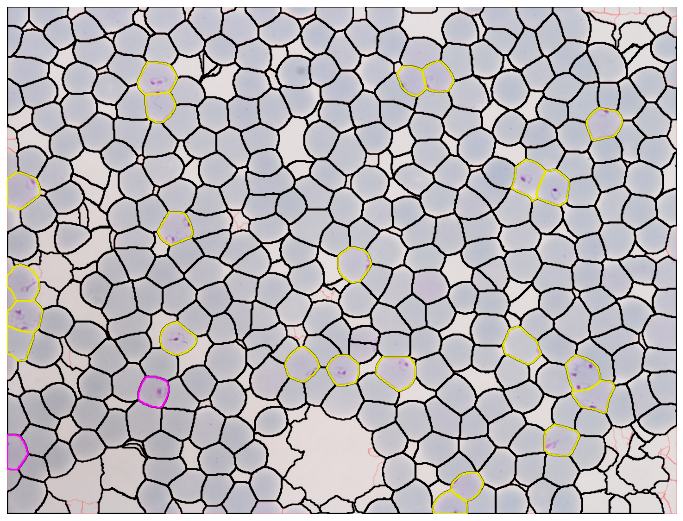

In [220]:
f, ax = plt.subplots(figsize = (12, 12))
# yellow: ring; magenta: troph; cyan: shiz

colors_stage = { "un": [0, 0, 0], "ring": [0.9, 0.9, 0], 
    "troph": [1, 0, 1], "shiz": [0, 1, 1]
}
ax.imshow(imgout)
ax.axis('off')
for k in class_names:
    if len(d_results[k]) > 0:
        for cell in d_results[k]:
            coord = outlines_ls[cell]
            ax.plot(coord[:,0], coord[:,1], color = colors_stage[k], lw=1.5)


In [266]:
df_res = pd.DataFrame.from_dict(d_results, orient = 'index').stack().reset_index()
df_res.columns = ['stage', '_' ,'cell_idx']
del df_res["_"]
df_res = df_res.groupby('stage').count().reset_index()
df_res['paras'] = df_res.cell_idx/total_count*100

In [268]:
print(df_res)

   stage  cell_idx      paras
0   ring        23   5.502392
1  troph         2   0.478469
2     un       393  94.019139


In [205]:
d_results

{'un': [13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  23,
  24,
  25,
  26,
  27,
  29,
  30,
  31,
  32,
  33,
  34,
  36,
  37,
  38,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  68,
  70,
  71,
  72,
  73,
  74,
  76,
  77,
  78,
  79,
  80,
  82,
  84,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  126,
  127,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  138,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  159,
  160,
  161,
  164,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  178,
  179,
  181,
  182,
  183,
  185,
  187,
  189,
  190,
  191,

In [232]:
total_count = sum(len(v)for v in d_results.values())
print (f"Final cell count: {total_count}")
print("Type    Count    %")
for key, value in d_results.items():
    stage_count = len([item for item in value if item])
    print(f"{key}:    {stage_count}   {stage_count/total_count*100:.3f}")

Final cell count: 418
Type    Count    %
un:    393   94.019
ring:    23   5.502
troph:    2   0.478
shiz:    0   0.000


#### Plotting using find_objects

In [ ]:
inf_cells = np.where(ar_preds > 0)

In [ ]:
f, ax = plt.subplots(figsize = (12, 12))

ax.imshow(img)
for idx in inf_cells[0]:
    ax.plot(ls_outlines[idx][0], ls_outlines[idx][1], color = colors_stage[results[idx]], lw=2)

In [ ]:
arr_results = np.array(results)
total_cells = arr_results.size 

In [ ]:
filename

### Batch inference

In [ ]:
%%timeit
ls_img = []
for idx, cell in enumerate(outlines_ls[:]):
    
    x = cell.flatten()[::2]
    y = cell.flatten()[1::2]

    if (y.max() - y.min()) < size_thres or (x.max() - x.min()) < size_thres:
        continue

    # mask outline
    mask = np.zeros(img.shape, dtype=np.uint8)
    channel_count = tmp_img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,)*channel_count
    # fill contour
    cv2.fillConvexPoly(mask, cell, ignore_mask_color)

    masked_image = cv2.bitwise_and(tmp_img, mask)

    # crop the box around the cell
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = masked_image[topy:bottomy+1, topx:bottomx+1,:]
#     out_scaled = cv2.resize(out, (224, 224), interpolation = cv2.INTER_AREA)
    tensor = transform_image(out)
    ls_img.append(tensor)

img_tensor = torch.cat(ls_img, dim=0)
bs = 128
ls_preds = []
part = img_tensor.shape[0]//bs
for p in range(part+1):
    outputs = model.forward(img_tensor[bs*p:bs*p + bs])
    ls_preds.append(outputs.data.numpy().argmax(1))
pred_ar = np.concatenate(ls_preds)
results = [class_names[x] for x in pred_ar] 

In [ ]:
len(results)